In [1]:
import os
os.chdir('../')

In [2]:
import pickle
import itertools

from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, KFold
from xgboost.sklearn import XGBClassifier

In [4]:
data = pd.read_csv('data/cac40_v3.csv').drop('Unnamed: 0', axis=1)
data

,TICKER,annee,mois,jour,OP,UP,DO,CL,VO,RDMT_J,...,strategique,transaction,actionnaires,coentreprise,construction,collaboration,developpement,l_acquisition,participation,recommandation
0,AC,2007,10,1,50.820,52.450,50.720,52.440,939518,0.045576,...,0,0,0,0,0,0,0,0,0,0
1,AC,2007,10,10,57.600,57.900,56.480,56.740,1167710,0.005640,...,0,0,0,0,0,0,0,0,0,0
2,AC,2007,10,11,56.570,57.900,56.570,57.060,910369,-0.005258,...,0,0,0,0,0,0,0,0,0,0
3,AC,2007,10,12,57.100,57.100,55.500,56.760,996349,-0.011628,...,0,0,0,0,0,0,0,0,0,0
4,AC,2007,10,15,56.760,57.290,55.770,56.100,573647,-0.003209,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106537,VIV,2017,9,4,20.065,20.235,20.030,20.100,2250835,0.002736,...,0,0,0,0,0,0,0,0,0,0
106538,VIV,2017,9,5,20.095,20.290,19.985,20.155,3095238,-0.001985,...,0,0,0,0,0,0,0,0,0,0
106539,VIV,2017,9,6,20.080,20.210,20.015,20.115,2181925,-0.006463,...,0,0,0,0,0,0,0,0,0,0
106540,VIV,2017,9,7,20.185,20.185,19.920,19.985,4038684,-0.002252,...,0,0,0,0,0,0,0,0,0,0


# Filtration des données
***

In [5]:
variables_num_dep = ["RDMT_J", "RDMT_S", "RDMT_M"]
variables_num_explic = ["OP", "UP", "DO", "CL", "VO"] + [f"{var}_{x}" for x in ["J", "S", "M"] for var in ["HISTO", "VOL", "UP", "DO"]]
numeric_variables = variables_num_dep + variables_num_explic
non_numeric_variables = data.columns[~data.columns.isin(numeric_variables)]
words = non_numeric_variables[4:]
descriptive_variables = non_numeric_variables[:4]

### Question 3)

Q : Montrer que, _quelque soit le ticker_, la liste des mots apparaissant sur 400 lignes et dont le rendement mensuel est en moyenne supérieur à 1% est telle que la table dans le sujet.  

In [6]:
# On veut l'effet du mot, indépendamment de ticker
freq_word_ret = {}
for word in words:
    if data[word].sum() > 400:
        mean_return = np.mean(data["RDMT_M"].loc[data[word] == 1])
        num_app = data[word].sum()
        if mean_return > 0.01:
            freq_word_ret[word] = (num_app, mean_return)

In [7]:
df = pd.DataFrame(freq_word_ret).transpose().rename(axis='columns', mapper={0:"Nombre d'apparitions", 1:"Rendement mensuel moyen"})
df["Nombre d'apparitions"] = df["Nombre d'apparitions"].astype('int64')
df.index.name = "Mot"
df

,Nombre d'apparitions,Rendement mensuel moyen
Mot,,
part,716,0.011925
plus,418,0.010119
pour,1966,0.013645
euros,446,0.010361
group,493,0.012940
passe,527,0.013763
titre,467,0.012178
groupe,467,0.014646
nouvel,494,0.011500


<b>Filtrer la base sur l'apparition de ces mots</b>

In [8]:
keepers = list(freq_word_ret.keys())
data["KEEP_ROW"] = data[keepers].sum(axis=1)
data = data.loc[~(data["KEEP_ROW"] == 0)].drop("KEEP_ROW", axis=1).reset_index(drop=True)

In [9]:
data.shape

(7129, 280)

### Question 4)

Q : Retrait des variables trop corrélées (positivement ou négativement).

In [10]:
CORRELATION_THRESHOLD = 0.75
correlation_matrix = data.loc[:,~data.columns.isin(["TICKER", "annee", "mois", "jour"])].corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
high_corr_vars = [col for col in upper_triangle.columns if any(upper_triangle[col] > CORRELATION_THRESHOLD)]

In [11]:
data.drop(high_corr_vars, axis=1, inplace=True)
data

,TICKER,annee,mois,jour,OP,VO,RDMT_J,RDMT_S,RDMT_M,HISTO_J,...,strategique,transaction,actionnaires,coentreprise,construction,collaboration,developpement,l_acquisition,participation,recommandation
0,AC,2010,10,11,27.370,583747,0.020663,0.065797,0.123255,0.009700,...,0,0,0,0,0,0,0,0,0,0
1,AC,2010,10,28,29.220,752703,0.011500,0.053896,0.117920,-0.003251,...,0,0,0,0,0,0,0,0,0,0
2,AC,2010,10,6,26.950,1747197,-0.022407,0.042645,0.132093,0.030540,...,0,0,0,0,0,0,0,0,0,0
3,AC,2010,11,26,33.415,871648,-0.022133,-0.012626,0.001485,0.001339,...,0,0,0,0,0,0,0,0,0,0
4,AC,2010,11,3,29.745,880633,0.029165,0.040898,0.126383,0.004715,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7124,VIV,2017,9,20,21.075,2787945,-0.004282,-0.011180,-0.025690,-0.007085,...,0,0,0,0,0,0,0,0,0,0
7125,VIV,2017,9,25,20.710,2082640,-0.001445,0.037581,-0.002891,0.000482,...,0,0,0,0,0,0,0,0,0,0
7126,VIV,2017,9,26,20.765,1622952,0.002895,0.032569,-0.008203,-0.001445,...,0,0,0,0,0,0,0,0,0,0
7127,VIV,2017,9,29,21.060,6358735,0.005369,-0.012138,0.014006,0.029066,...,0,0,0,0,0,0,0,0,0,0


### Question 5)

Q : Choisir un algorithme parmi les suivants :
- XGBoost <b>X</b>
- GradientBoostingClassifier
- neural_network.MLPClassifier

**_Qu'est-ce que l'algorithme XGBoost?_**

_XGBoost_, de son nom _Extreme Gradient Boosting_ est un algorithme construit pour optimiser l'algorithme _Gradient Boosting_, qui est lui-même une variante du _Random Forest_. GB fait des prédicitions grâce à un ensemble d'arbres de décision qui "votent" pour la prédiction finale. Au différent de _Random Forest_, la construction même de l'ensemble d'arbres est faite de manière séquentielle de sorte à minimiser la fonction objectif par déscente de gradients.
_XGBoost_ cherche à optimiser l'implémentation de GB, notamment en parallélisant la construction des arbres et en optimisant l'utilisation de resources physiques disponibles.

### Question 6)

Q : Analyser les hyperparamètres et assurer un grid computing d'environ 100 n-uplets de paramètres. Une cross-validation de 4 folds est souhaitée.

D'après la [documentation officielle](https://xgboost.readthedocs.io/en/latest/parameter.html) de XGBoost il y a trois types de paramètres qui vont nous concerner dans cette étude.
> 1. **Paramètres Géneraux**: paramètres liés au choix de technique de boosting (avec modèle linéaire ou arbre de décisions)
> 2. **Paramètres de "booster"**: paramètres du booster choisi &rarr; concernent le _Bias-Variance tradeoff_
>> - learning_rate \[défault = 0.3] : contrôle le poids des features utilisées pour rendre l'algo plus conservateur (réduire possibilité d'overfit).
>> - min_child_weight \[defaut = 1] : définit le poids minimal d'un noeud enfant pour qu'il soit créé. Contrôle l'importance des relation à apprendre et donc l'overfitting.
>> - max_depth \[défaut = 6] : la profondeur maximale de chaque arbre créé. Contrôle contre l'overfit.
>> - gamma \[défaut = 0] : valeur minimale d'amélioration de l'objectif requise par l'algorithme pour continuer la création d'un noeud enfant dans un arbre. Contrôle l'overfit.
> 3. **Paramètres d'apprentissage**: paramètres liés à la tâche entreprise (i.e. qu'est-ce qu'on apprend ? comment ?)
>> - objective : fonction objectif d'apprentissage

avec : 
- _Bias_ : L'erreur moyenne de l'algo dans un unique jeu de données (fit)
- _Variance_ : La variation des erreurs de l'algo entre plusieurs jeux de données (généralisation)

voire aussi :
- [Complete Guide to Parameter Tuning in XGBoost with codes in Python](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)

### DATA PREPROCESSING

In [12]:
from exploratory_notebooks.helper_functions import remove_outliers
from exploratory_notebooks.helper_functions import mean_encode
# remove outliers found related to volume
data = remove_outliers(data, ["VO"] + [f"VOL_{x}" for x in ["J", "S", "M"]]) # Note: Do this ONCE.
data.reset_index(drop=True, inplace=True)
data.shape

(6785, 247)

In [13]:
LABEL = "RDMT_M"

X = data.loc[:,~data.columns.isin(variables_num_dep)].copy()
y = data[LABEL].copy()
y_label = pd.DataFrame({'y':[1 if v > 0 else -1 for v in y]})
y_label = y_label.y

In [14]:
# define folds for cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size=0.2, random_state=42)

In [ ]:
# Fit the encoder on the training data to avoid leakage and encode tickers
ticker_encoder = mean_encode(X_train, y_train, "TICKER")
X_train.loc[:,"TICKER"] = X_train["TICKER"].apply(lambda x: ticker_encoder[x])
X_test.loc[:, "TICKER"] = X_test["TICKER"].apply(lambda x: ticker_encoder[x])

In [17]:
X_train

,TICKER,annee,mois,jour,OP,VO,HISTO_J,HISTO_S,HISTO_M,VOL_J,...,strategique,transaction,actionnaires,coentreprise,construction,collaboration,developpement,l_acquisition,participation,recommandation
4563,0.218884,2014,4,17,65.650,935173,0.013323,0.013484,-0.018738,0.089232,...,0,0,0,0,0,0,0,0,0,0
6123,0.221477,2014,11,17,8.951,3643737,0.000554,-0.005064,0.042565,-0.058646,...,0,0,0,0,0,0,0,0,0,0
149,0.099338,2016,2,18,34.995,2845023,0.027278,0.181575,0.018852,0.097772,...,0,0,0,0,0,0,0,0,1,0
3892,0.099237,2009,1,27,30.260,1884262,0.001329,-0.131662,-0.184082,-0.125978,...,0,0,0,0,0,0,0,0,0,0
5368,0.250000,2014,6,12,79.270,1628363,-0.000126,0.006595,0.034002,-0.324692,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,0.085106,2010,1,18,79.660,795435,0.017630,-0.010894,0.065392,-0.500627,...,0,0,0,0,0,0,0,0,0,0
5191,0.322917,2015,7,6,59.800,790724,-0.011475,-0.021580,-0.044677,0.176568,...,0,0,0,0,0,0,0,0,0,0
5226,0.322917,2016,4,26,63.100,1198065,0.009463,0.026251,0.019932,-0.011598,...,0,0,0,0,0,0,0,0,0,0
5390,0.250000,2015,2,17,85.470,2487298,-0.002217,0.003049,0.070061,0.627318,...,0,0,0,0,0,0,0,0,0,0


## HYPER PARAMETER TUNING

In [19]:
# define parameter bounds and compute parameter grid
hyper_learning_rate = np.logspace(-4,0,5)
hyper_max_depth = np.linspace(3,10,5).astype('int64')
hyper_min_child_weight = np.linspace(1,3,5).astype('int64')
hyper_gamma = np.linspace(0,2,5)

hyper_parameter_list = [hyper_learning_rate, hyper_max_depth, hyper_min_child_weight, hyper_gamma]
hyper_parameter_grid = list(itertools.product(*hyper_parameter_list))

In [20]:
len(hyper_parameter_grid)

625

In [21]:
from exploratory_notebooks.helper_functions import tune_XGB_hyper_params

results = tune_XGB_hyper_params(hyper_parameter_grid, X_train, y_train)

In [22]:
# #############################
# GET RESULTS FROM CACHE
# ############################

In [25]:
tuning_results = open("results/hyper_param_tuning_results.picke", "wb")
pickle.dump(results, tuning_results)
tuning_results.close()

'''with open("results/hyper_param_tuning_results.picke", 'rb') as file:
    results = pickle.load(file)'''

'with open("results/hyper_param_tuning_results.picke", \'rb\') as file:\n    results = pickle.load(file)'

In [26]:
from helper_functions import plot_tuning_results

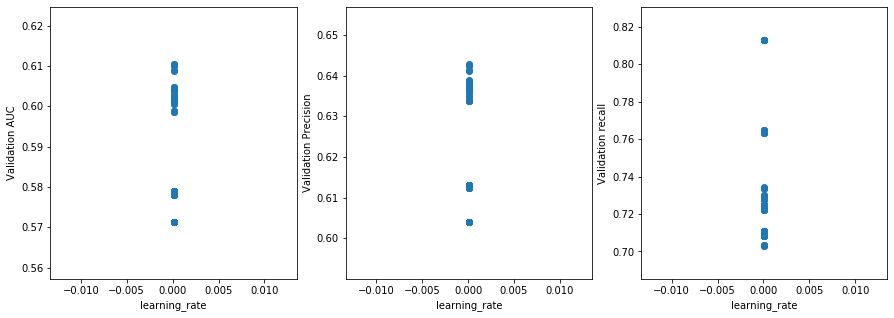

In [27]:
plot_tuning_results(results, 'learning_rate')

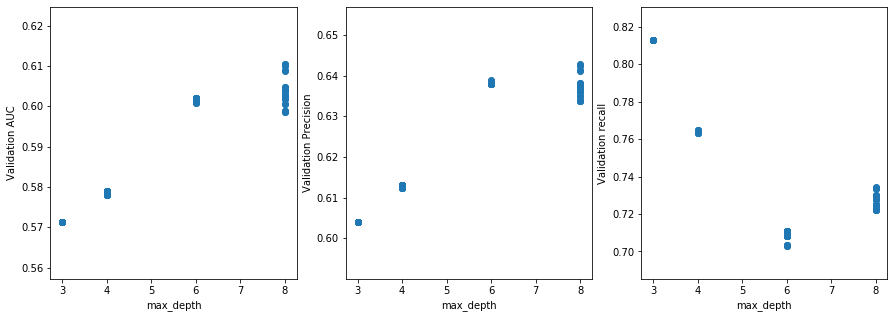

In [28]:
plot_tuning_results(results, 'max_depth')

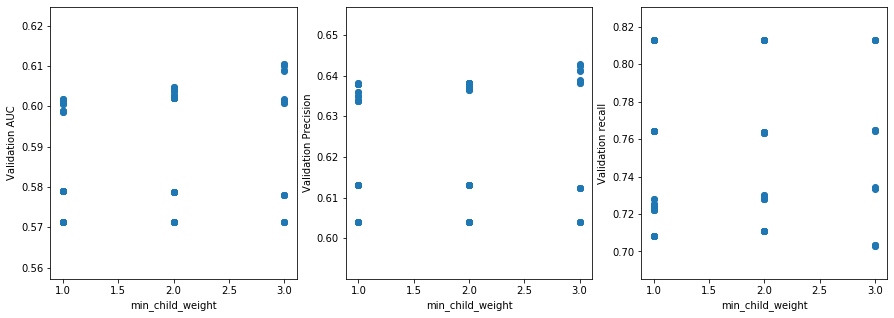

In [29]:
plot_tuning_results(results, 'min_child_weight')

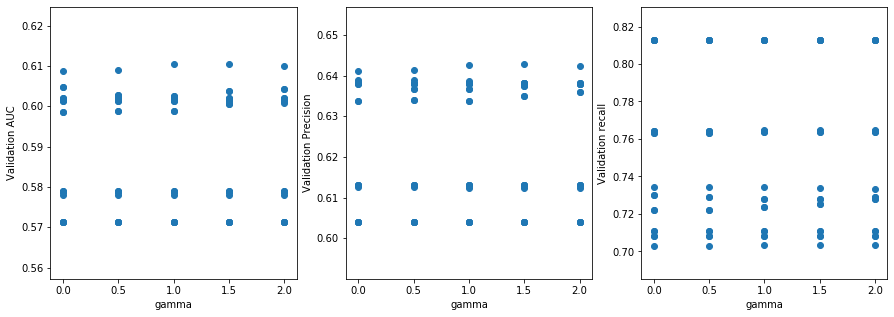

In [30]:
plot_tuning_results(results, 'gamma')

In [31]:
# Get "best" model as defined by L2 norm of computed metrics
#score_norms = [np.sqrt(pow(x['metriques']['auc'],2) + pow(x['metriques']['precision'],2) + pow(x['metriques']['recall'],2)) for x in results]
#max_score_norm = np.argmax(score_norms)
#max_score_norm_res = results[max_score_norm]
auc_scores = [x['metriques']['auc'] for x in results]
max_auc_ix = np.argmax(auc_scores)
max_auc_res = results[max_auc_ix]

In [32]:
learning_rate = max_auc_res['parametres']['learning_rate']
max_depth = max_auc_res['parametres']['max_depth']
min_child_weight = max_auc_res['parametres']['min_child_weight']
gamma = max_auc_res['parametres']['gamma']
xgb = XGBClassifier(learning_rate=learning_rate,
                    max_depth=max_depth,
                    min_child_weight=min_child_weight,
                    gamma=gamma)

In [33]:
model = xgb.fit(X_train, y_train)
y_test_pred = model.predict(X_test)

In [34]:
roc_auc_score(y_test_pred, y_test)

0.5992734825631318

## FEATURE IMPORTANCE

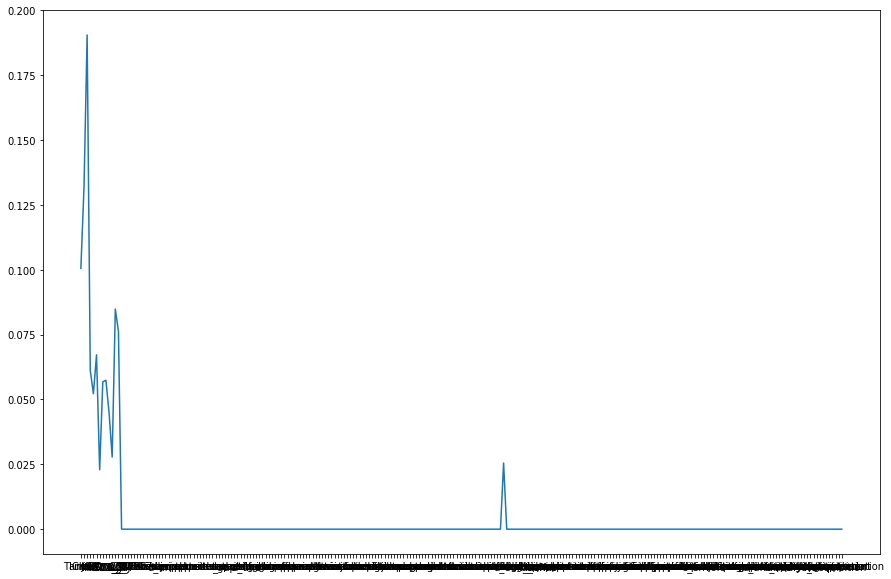

In [35]:
features = X_train.columns
importances = model.feature_importances_
plt.plot(features, importances)
plt.gcf().set_size_inches(15,10);

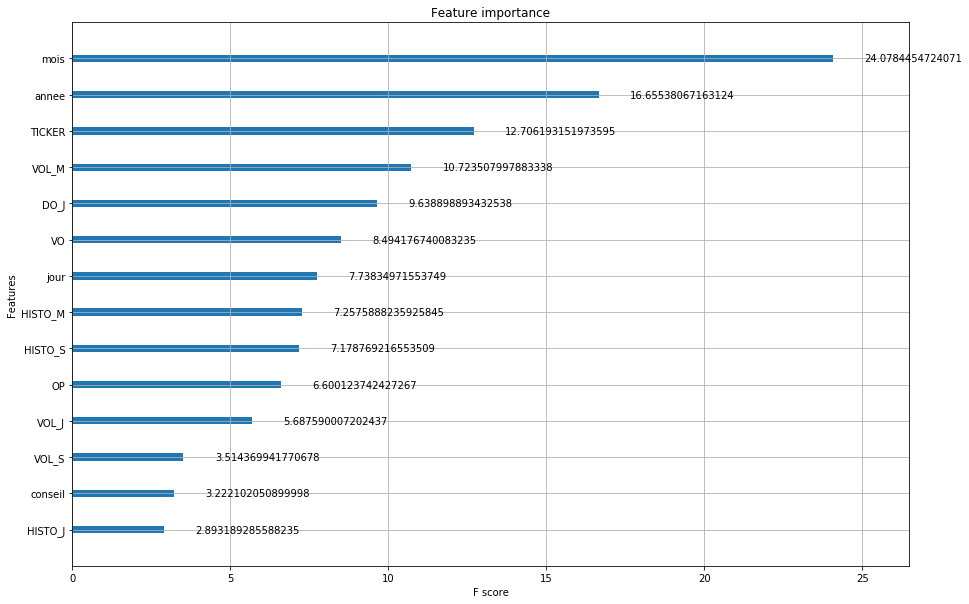

In [36]:
from xgboost import plot_importance
plot_importance(model, max_num_features=50, importance_type="gain")
plt.gcf().set_size_inches(15,10);

In [37]:
features = X_train.columns[~(importances == 0)]
X_1 = X[features]
X_1

,TICKER,annee,mois,jour,OP,VO,HISTO_J,HISTO_S,HISTO_M,VOL_J,VOL_S,VOL_M,DO_J,conseil
0,AC,2010,10,11,27.370,583747,0.009700,0.059332,0.067944,-0.356155,-0.381410,-0.403233,0.007604,0
1,AC,2010,10,28,29.220,752703,-0.003251,0.013923,0.106343,-0.264331,-0.632181,-0.327726,-0.008562,0
2,AC,2010,10,6,26.950,1747197,0.030540,0.041596,0.087230,0.924626,0.674942,3.056080,0.039738,0
3,AC,2010,11,26,33.415,871648,0.001339,0.051875,0.151754,-0.202305,0.909377,-0.148078,0.021306,0
4,AC,2010,11,3,29.745,880633,0.004715,0.020701,0.145545,1.098479,-0.139297,-0.066803,0.009384,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6780,VIV,2017,9,20,21.075,2787945,-0.007085,-0.010125,0.122863,-0.126979,-0.582803,0.040764,0.000238,0
6781,VIV,2017,9,25,20.710,2082640,0.000482,-0.006700,0.095540,-0.489023,0.115841,-0.357766,-0.000483,0
6782,VIV,2017,9,26,20.765,1622952,-0.001445,-0.021020,0.069401,-0.220724,-0.491786,-0.646569,0.000483,0
6783,VIV,2017,9,29,21.060,6358735,0.029066,0.032538,0.105834,1.942386,0.560121,0.222850,0.011377,0


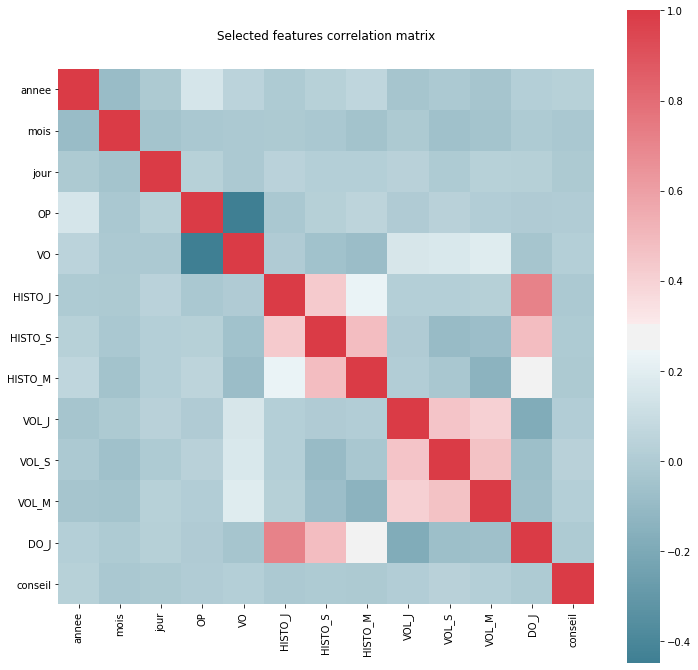

In [39]:
from exploratory_notebooks.helper_functions import plot_correlation_matrix

plot_correlation_matrix(X_1.corr(), "Selected features correlation matrix", 'seaborn')

In [40]:
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_label, test_size=0.2, random_state=42)

In [52]:
'''from helper_functions import tune_XGB_hyper_params
results_1 = tune_XGB_hyper_params(hyper_parameter_grid, X_1_train, y_1_train)'''
mean_encoder_1 = mean_encode(X_1_train, y_1_train, "TICKER")
X_1_train.loc[:, "TICKER"] = X_1_train["TICKER"].apply(lambda x: mean_encoder_1[x])
X_1_test.loc[:, "TICKER"] = X_1_test["TICKER"].apply(lambda x: mean_encoder_1[x])

/Users/Cisco/anaconda3/envs/MachineLearning/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [ ]:
'''with open('results/hyper_parameter_tuning_results_1.pickle', 'wb') as f:
    pickle.dump(results_1, f)'''
'''with open('results/hyper_parameter_tuning_results_1.pickle', 'rb') as f:
    results_1 = pickle.load(f)'''

In [49]:
max_auc_idx = np.argmax([x['metriques']['auc'] for x in results])
results[max_auc_idx]

{'algorithm': 'XGBClassifier',
 'parametres': {'learning_rate': 0.0001,
  'max_depth': 8,
  'min_child_weight': 3,
  'gamma': 1.5},
 'metriques': {'auc': 0.6105, 'precision': 0.6428, 'recall': 0.7338}}

In [50]:
learning_rate_1 = results[max_auc_idx]['parametres']['learning_rate']
max_depth_1 = results[max_auc_idx]['parametres']['max_depth']
min_child_weight_1 = results[max_auc_idx]['parametres']['min_child_weight']
gamma_1 = results[max_auc_idx]['parametres']['gamma']

In [53]:
xgb = XGBClassifier(learning_rate=learning_rate,
                     max_depth=max_depth,
                     min_child_weight=min_child_weight,
                     gamma=gamma)
model = xgb.fit(X_1_train, y_1_train)
y_1_pred = model.predict(X_1_test)
auc = roc_auc_score(y_1_pred, y_1_test)
auc

0.5992734825631318